Мы разобрались с тем, что такое среда для обучения и каким образом можно управлять агентом с помощью случайной стратегии. Уже немало, но наша задача куда амбициознее: научиться управлять агентом хорошо! Чтобы его действия приносили как можно больший доход. Чтобы достичь цели, будем двигаться небольшими шагами, разбирая основы и совершенствуя схемы управления с помощью методов обучения с подкреплением.

In [ ]:
!pip install gym pyvirtualdisplay atari-py > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import torch

In [ ]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

В зависимости от задачи, среды обучения будут меняться, но в этот раз нам снова помогает наш друг - обратный маятник. Мы будем запускать его в режиме эпизодов (т.е. с ограниченным числом шагов симуляции) и анализировать полученное вознаграждение.

In [ ]:
env = wrap_env(gym.make('CartPole-v0'))

In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

In [ ]:
def run_episode(env, weight):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))
        state, reward, is_done, _ = env.step(action.item())
        total_reward += reward
    return total_reward

Подбор весов с помощью стратегии случайного поиска:

0. best_weight = None, best_total_reward = 0
1. В начале каждого эпизода генерируем случайный вектор весов weight
2. Запускаем эпизод с этим весом run_episode(env, weight)
3. Если вознаграждение, полученное за эпизод больше текущего максимального, то обновляем вес

In [ ]:
n_episode = 1000

best_total_reward = 0
best_weight = None

total_rewards = []

In [ ]:
for episode in range(n_episode):
    weight = torch.rand(n_state, n_action)
    total_reward = run_episode(env, weight)
    if (episode + 1) % 50 == 0:
      print('Episode {}: {}'.format(episode+1, total_reward))
    if total_reward > best_total_reward:
        best_weight = weight
        best_total_reward = total_reward
    total_rewards.append(total_reward)

print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards) / n_episode))

Episode 50: 117.0
Episode 100: 63.0
Episode 150: 61.0
Episode 200: 9.0
Episode 250: 10.0
Episode 300: 72.0
Episode 350: 128.0
Episode 400: 10.0
Episode 450: 200.0
Episode 500: 8.0
Episode 550: 10.0
Episode 600: 9.0
Episode 650: 76.0
Episode 700: 76.0
Episode 750: 10.0
Episode 800: 12.0
Episode 850: 22.0
Episode 900: 8.0
Episode 950: 57.0
Episode 1000: 8.0
Average total reward over 1000 episode: 46.053


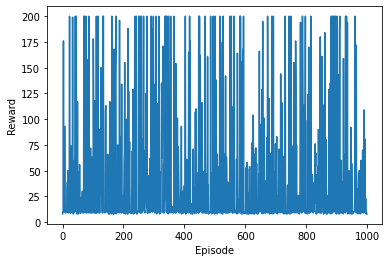

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Как можно видеть на графике выше, алгоритм действует достаточно бессистемно, меняя каждый раз веса на новый случайны набор. Но тем не менее довольно большое число попыток дают хороший результат. 

Воспользуемся вычисленным весом, чтобы управлять движением обратного маятника, и посмотрим на вознаграждение

In [ ]:
n_episode_eval = 100
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env, best_weight)
    if (episode + 1) % 10 == 0:
      print('Episode {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)


print('Average total reward over {} episode: {}'.format(n_episode, sum(total_rewards_eval) / n_episode_eval))

Episode 10: 200.0
Episode 20: 200.0
Episode 30: 200.0
Episode 40: 200.0
Episode 50: 200.0
Episode 60: 200.0
Episode 70: 200.0
Episode 80: 200.0
Episode 90: 200.0
Episode 100: 200.0
Average total reward over 1000 episode: 199.95


Результат выглядит неплохо. Но секрет нашего успеха в том, что сама задача достаточно проста, так будет не всегда. Поэтому полезно будет разобрать более сложные схемы обучения.